In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
import os
path = './LogiReg_data.txt'
pdData = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
pdData.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [9]:
pdData.shape # 查看数据的维度 （数据个数，数据3列）

(100, 3)

Text(0, 0.5, 'Exam 2 Score')

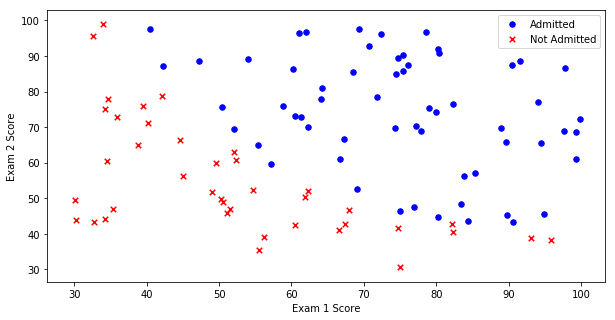

In [13]:
positive = pdData[pdData['Admitted'] == 1] # returns the subset of rows such Admitted = 1, i.e. the set of *positive* examples
negative = pdData[pdData['Admitted'] == 0] # returns the subset of rows such Admitted = 0, i.e. the set of *negative* examples

fig, ax = plt.subplots(figsize=(10,5))# 画图域 长宽
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=30, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=30, c='r', marker='x', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

In [14]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

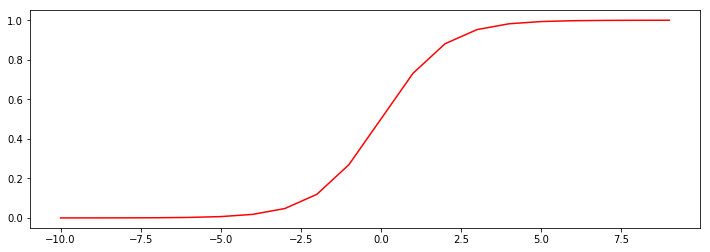

In [17]:
nums = np.arange(-10, 10, step=1)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(nums, sigmoid(nums), 'r')

In [18]:
def model(X, theta):
    return sigmoid(np.dot(X, theta.T))

In [20]:
pdData.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
orig_data = pdData.as_matrix() # convert the Pandas representation of the data to an array useful for further computations
cols = orig_data.shape[1]
X = orig_data[:,0:cols-1]
y = orig_data[:,cols-1:cols]

# convert to numpy arrays and initalize the parameter array theta
#X = np.matrix(X.values)
#y = np.matrix(data.iloc[:,3:4].values) #np.array(y.values)
theta = np.zeros([1, 3])

ValueError: cannot insert Ones, already exists

In [22]:
X[:5]

array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644]])

In [23]:
y[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.]])

In [24]:
theta

array([[0., 0., 0.]])

In [25]:
X.shape, y.shape, theta.shape

((100, 3), (100, 1), (1, 3))

In [26]:
def cost(X, y, theta):
    left = np.multiply(-y, np.log(model(X, theta)))
    right = np.multiply(1 - y, np.log(1 - model(X, theta)))
    return np.sum(left - right) / (len(X))

In [27]:
cost(X, y, theta)

0.6931471805599453

In [28]:
def gradient(X, y, theta):
    grad = np.zeros(theta.shape)
    error = (model(X, theta)- y).ravel()
    for j in range(len(theta.ravel())): #for each parmeter
        term = np.multiply(error, X[:,j])
        grad[0, j] = np.sum(term) / len(X)
    
    return grad

In [29]:
STOP_ITER = 0
STOP_COST = 1
STOP_GRAD = 2

def stopCriterion(type, value, threshold):
    #设定三种不同的停止策略
    if type == STOP_ITER:        return value > threshold
    elif type == STOP_COST:      return abs(value[-1]-value[-2]) < threshold
    elif type == STOP_GRAD:      return np.linalg.norm(value) < threshold

In [30]:
import numpy.random
#洗牌
def shuffleData(data):
    np.random.shuffle(data)
    cols = data.shape[1]
    X = data[:, 0:cols-1]
    y = data[:, cols-1:]
    return X, y

In [31]:
import time

def descent(data, theta, batchSize, stopType, thresh, alpha):
    #梯度下降求解
    
    init_time = time.time()
    i = 0 # 迭代次数
    k = 0 # batch
    X, y = shuffleData(data)
    grad = np.zeros(theta.shape) # 计算的梯度
    costs = [cost(X, y, theta)] # 损失值

    
    while True:
        grad = gradient(X[k:k+batchSize], y[k:k+batchSize], theta)
        k += batchSize #取batch数量个数据
        if k >= n: 
            k = 0 
            X, y = shuffleData(data) #重新洗牌
        theta = theta - alpha*grad # 参数更新
        costs.append(cost(X, y, theta)) # 计算新的损失
        i += 1 

        if stopType == STOP_ITER:       value = i
        elif stopType == STOP_COST:     value = costs
        elif stopType == STOP_GRAD:     value = grad
        if stopCriterion(stopType, value, thresh): break
    
    return theta, i-1, costs, grad, time.time() - init_time

In [32]:
def runExpe(data, theta, batchSize, stopType, thresh, alpha):
    #import pdb; pdb.set_trace();
    theta, iter, costs, grad, dur = descent(data, theta, batchSize, stopType, thresh, alpha)
    name = "Original" if (data[:,1]>2).sum() > 1 else "Scaled"
    name += " data - learning rate: {} - ".format(alpha)
    if batchSize==n: strDescType = "Gradient"
    elif batchSize==1:  strDescType = "Stochastic"
    else: strDescType = "Mini-batch ({})".format(batchSize)
    name += strDescType + " descent - Stop: "
    if stopType == STOP_ITER: strStop = "{} iterations".format(thresh)
    elif stopType == STOP_COST: strStop = "costs change < {}".format(thresh)
    else: strStop = "gradient norm < {}".format(thresh)
    name += strStop
    print ("***{}\nTheta: {} - Iter: {} - Last cost: {:03.2f} - Duration: {:03.2f}s".format(
        name, theta, iter, costs[-1], dur))
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + ' - Error vs. Iteration')
    return theta

***Original data - learning rate: 1e-06 - Gradient descent - Stop: 5000 iterations
Theta: [[-0.00027127  0.00705232  0.00376711]] - Iter: 5000 - Last cost: 0.63 - Duration: 0.76s


array([[-0.00027127,  0.00705232,  0.00376711]])

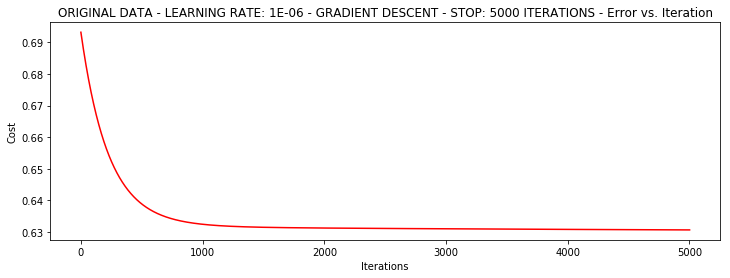

In [33]:
#选择的梯度下降方法是基于所有样本的
n=100
runExpe(orig_data, theta, n, STOP_ITER, thresh=5000, alpha=0.000001)

***Original data - learning rate: 0.001 - Gradient descent - Stop: costs change < 1e-06
Theta: [[-5.13364014  0.04771429  0.04072397]] - Iter: 109901 - Last cost: 0.38 - Duration: 17.02s


array([[-5.13364014,  0.04771429,  0.04072397]])

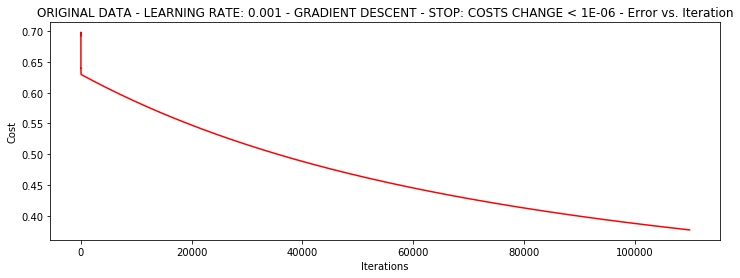

In [34]:
runExpe(orig_data, theta, n, STOP_COST, thresh=0.000001, alpha=0.001)

***Original data - learning rate: 0.001 - Gradient descent - Stop: gradient norm < 0.05
Theta: [[-2.37033409  0.02721692  0.01899456]] - Iter: 40045 - Last cost: 0.49 - Duration: 6.40s


array([[-2.37033409,  0.02721692,  0.01899456]])

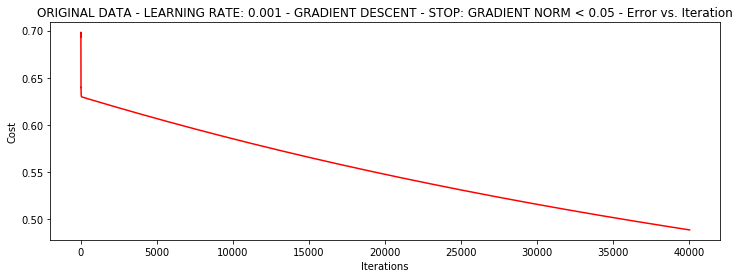

In [35]:
runExpe(orig_data, theta, n, STOP_GRAD, thresh=0.05, alpha=0.001)

***Original data - learning rate: 0.001 - Stochastic descent - Stop: 5000 iterations
Theta: [[-0.38151881  0.09093535  0.01910635]] - Iter: 5000 - Last cost: 2.16 - Duration: 0.23s


array([[-0.38151881,  0.09093535,  0.01910635]])

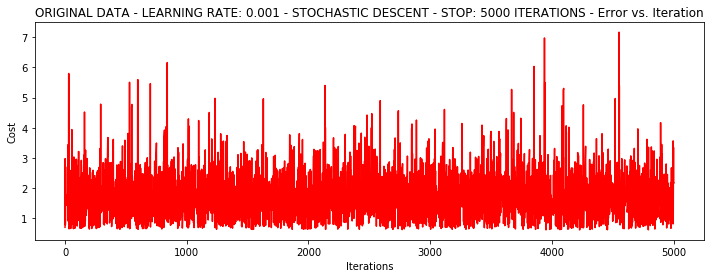

In [36]:
runExpe(orig_data, theta, 1, STOP_ITER, thresh=5000, alpha=0.001)

***Original data - learning rate: 2e-06 - Stochastic descent - Stop: 50000 iterations
Theta: [[-0.00691578  0.01038501  0.00048064]] - Iter: 50000 - Last cost: 0.63 - Duration: 2.27s


array([[-0.00691578,  0.01038501,  0.00048064]])

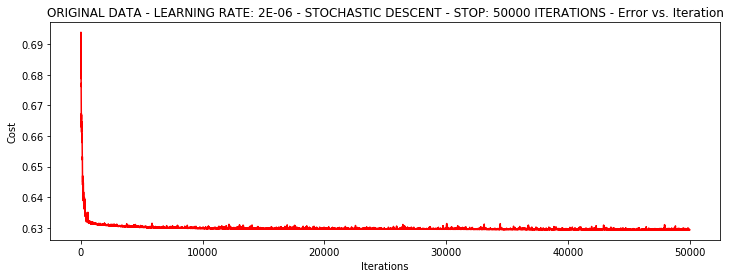

In [39]:
runExpe(orig_data, theta, 1, STOP_ITER, thresh=50000, alpha=0.000002)

***Original data - learning rate: 0.001 - Mini-batch (16) descent - Stop: 15000 iterations
Theta: [[-1.03790447  0.02179309 -0.01364263]] - Iter: 15000 - Last cost: 0.75 - Duration: 0.93s


array([[-1.03790447,  0.02179309, -0.01364263]])

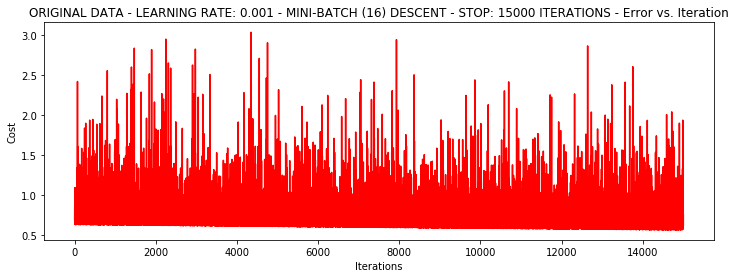

In [40]:
runExpe(orig_data, theta, 16, STOP_ITER, thresh=15000, alpha=0.001)

C:\Program Files (x86)\python\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Program Files (x86)\python\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Program Files (x86)\python\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Program Files (x86)\python\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Program Files (x86)\python\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary inc

***Scaled data - learning rate: 0.001 - Gradient descent - Stop: 5000 iterations
Theta: [[0.3080807  0.86494967 0.77367651]] - Iter: 5000 - Last cost: 0.38 - Duration: 0.82s


array([[0.3080807 , 0.86494967, 0.77367651]])

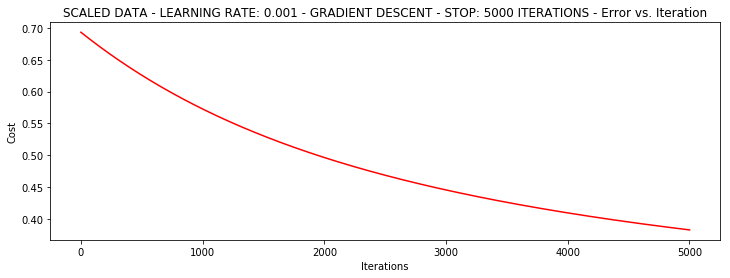

In [41]:
from sklearn import preprocessing as pp

scaled_data = orig_data.copy()
scaled_data[:, 1:3] = pp.scale(orig_data[:, 1:3])

runExpe(scaled_data, theta, n, STOP_ITER, thresh=5000, alpha=0.001)

***Scaled data - learning rate: 0.001 - Gradient descent - Stop: gradient norm < 0.02
Theta: [[1.0707921  2.63030842 2.41079787]] - Iter: 59422 - Last cost: 0.22 - Duration: 9.98s


array([[1.0707921 , 2.63030842, 2.41079787]])

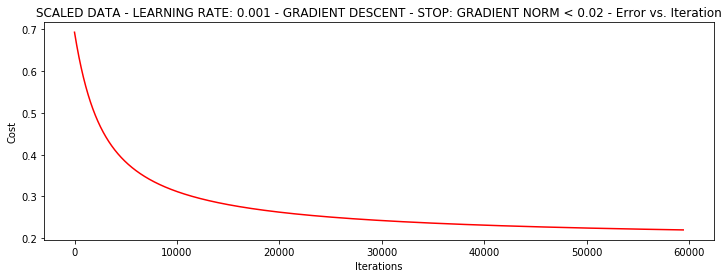

In [42]:
runExpe(scaled_data, theta, n, STOP_GRAD, thresh=0.02, alpha=0.001)

***Scaled data - learning rate: 0.001 - Stochastic descent - Stop: gradient norm < 0.0004
Theta: [[1.14841776 2.7926059  2.56608142]] - Iter: 72596 - Last cost: 0.22 - Duration: 4.06s


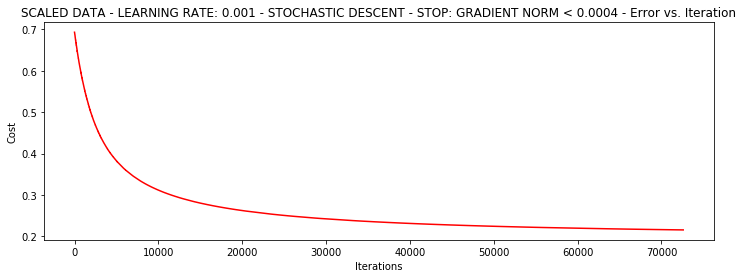

In [43]:
theta = runExpe(scaled_data, theta, 1, STOP_GRAD, thresh=0.002/5, alpha=0.001)

***Scaled data - learning rate: 0.001 - Mini-batch (16) descent - Stop: gradient norm < 0.004
Theta: [[1.15551658 2.80882898 2.58333892]] - Iter: 1504 - Last cost: 0.22 - Duration: 0.11s


array([[1.15551658, 2.80882898, 2.58333892]])

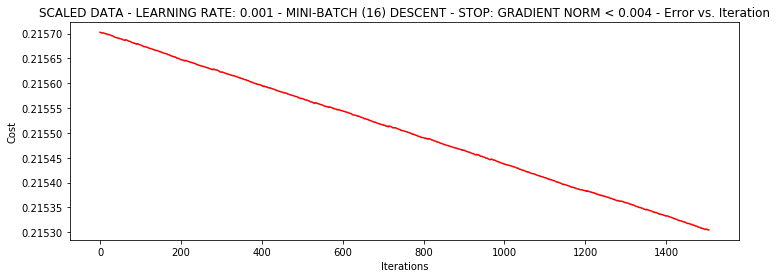

In [47]:
runExpe(scaled_data, theta, 16, STOP_GRAD, thresh=0.002*2, alpha=0.001)

In [48]:
#设定阈值
def predict(X, theta):
    return [1 if x >= 0.5 else 0 for x in model(X, theta)]

In [49]:
scaled_X = scaled_data[:, :3]
y = scaled_data[:, 3]
predictions = predict(scaled_X, theta)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print ('accuracy = {0}%'.format(accuracy))

accuracy = 89%
